# Assignment 6 - Reproducibility and Hyperparameter Search in ML

Team 25, Members:     



| Name | Roll Number |  
| ------ | ------ |  
| Romit Mohane | 23110279 |  
| Rudra Pratap Singh | 23110281 |  

## Introduction
The goal of this assignment is to learn about experiment tracking, version control, and reproducibility in machine learning workflows. You will set up experiment tracking using Weights and Biases.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

KeyboardInterrupt: 

## Section 1: MLP Model Implementation & Experiment Tracking

### 1. Implement a Multi-Layer Perceptron (MLP) Using the Iris Dataset (05%)
  - Load the Iris dataset using `sklearn.datasets.load_iris`


In [ ]:
data = load_iris()

- Extract features and labels, ensuring labels are `one-hot` encoded.

In [ ]:
X = data.data
y = data.target.reshape(-1, 1)
encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(y)
X[:10], y[:10]    # seeing first 10

(array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1]]),
 array([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]]))

- Normalize feature values to **[0,1]** using standard scaling.

In [ ]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled[:10]

array([[0.22222222, 0.625     , 0.06779661, 0.04166667],
       [0.16666667, 0.41666667, 0.06779661, 0.04166667],
       [0.11111111, 0.5       , 0.05084746, 0.04166667],
       [0.08333333, 0.45833333, 0.08474576, 0.04166667],
       [0.19444444, 0.66666667, 0.06779661, 0.04166667],
       [0.30555556, 0.79166667, 0.11864407, 0.125     ],
       [0.08333333, 0.58333333, 0.06779661, 0.08333333],
       [0.19444444, 0.58333333, 0.08474576, 0.04166667],
       [0.02777778, 0.375     , 0.06779661, 0.04166667],
       [0.16666667, 0.45833333, 0.08474576, 0.        ]])

- Split the dataset into:
  - **Training set**: 70%
  - **Validation set**: 10%
  - **Testing set**: 20%.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/8, random_state=42, stratify=y_train)
print("Size of training set:", len(X_train))
print("Size of validation set:", len(X_val))
print("Size of testing set:", len(X_test))

Size of training set: 105
Size of validation set: 15
Size of testing set: 30


### 2. Define and Train the MLP Model (05%)


In [ ]:
# converting the above arrays to PyTorch Tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val   = torch.tensor(X_val, dtype=torch.float32)
y_val   = torch.tensor(y_val, dtype=torch.float32)
X_test  = torch.tensor(X_test, dtype=torch.float32)
y_test  = torch.tensor(y_test, dtype=torch.float32)

- Construct a Multi-Layer Perceptron (MLP) model with the following architecture:
  - Input layer: 4 neurons (for 4 features).
  - Hidden layer: 16 neurons, ReLU activation.
  - Output layer: 3 neurons (for each class), softmax activation.

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        # since CrossEntropLoss already calculates Softmax of the logits, no need to define here
        return x


input_size = 4
hidden_size = 16
output_size = 3
model = MLP(input_size, hidden_size, output_size)
model

MLP(
  (fc1): Linear(in_features=4, out_features=16, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=16, out_features=3, bias=True)
)

- Train using:
  - Loss function: `Categorical cross-entropy`.
  - Optimizer: `Adam`.
  - Learning rate: `0.001`.
  - Batch size: `32`.
  - Epochs: `50`.
- Track and store both training and validation loss during training.


In [ ]:
# Create data loaders
train_data = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)

val_data = torch.utils.data.TensorDataset(X_val, y_val)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=False)

test_data = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_losses = []
epochs = 50
for epoch in range(epochs):
  train_loss = 0
  model.train()  # set the model to training mode
  for batch_X, batch_y in train_loader:
    outputs = model(batch_X)
    loss = criterion(outputs, torch.argmax(batch_y, dim=1))

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

  train_loss /= len(train_loader)
  train_losses.append(train_loss)


  # Validation
  model.eval() # Set the model to evaluation mode
  with torch.no_grad():
    val_loss = 0
    for batch_X, batch_y in val_loader:
        outputs = model(batch_X)
        val_loss += criterion(outputs, torch.argmax(batch_y, dim=1)).item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

  print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')

Epoch [1/50], Loss: 1.0929, Val Loss: 1.1286
Epoch [2/50], Loss: 1.1308, Val Loss: 1.1277
Epoch [3/50], Loss: 1.0725, Val Loss: 1.1267
Epoch [4/50], Loss: 1.0929, Val Loss: 1.1258
Epoch [5/50], Loss: 1.1197, Val Loss: 1.1250
Epoch [6/50], Loss: 1.1305, Val Loss: 1.1240
Epoch [7/50], Loss: 1.1142, Val Loss: 1.1228
Epoch [8/50], Loss: 1.0941, Val Loss: 1.1216
Epoch [9/50], Loss: 1.1038, Val Loss: 1.1205
Epoch [10/50], Loss: 1.1101, Val Loss: 1.1193
Epoch [11/50], Loss: 1.0693, Val Loss: 1.1181
Epoch [12/50], Loss: 1.0879, Val Loss: 1.1170
Epoch [13/50], Loss: 1.0865, Val Loss: 1.1160
Epoch [14/50], Loss: 1.0519, Val Loss: 1.1149
Epoch [15/50], Loss: 1.0459, Val Loss: 1.1141
Epoch [16/50], Loss: 1.0676, Val Loss: 1.1134
Epoch [17/50], Loss: 1.0592, Val Loss: 1.1125
Epoch [18/50], Loss: 1.0792, Val Loss: 1.1116
Epoch [19/50], Loss: 1.0192, Val Loss: 1.1106
Epoch [20/50], Loss: 1.0985, Val Loss: 1.1097
Epoch [21/50], Loss: 1.0413, Val Loss: 1.1086
Epoch [22/50], Loss: 1.0301, Val Loss: 1.10

### 3. Evaluate Model Performance (10%)

- Compute and store the following metrics using the test set:
  - **Accuracy**
  - **Precision**
  - **Recall**
  - **F1-score**
  - **Confusion matrix** (visualized using Matplotlib).



Accuracy: 0.7000
Precision: 0.5350
Recall: 0.7000
F1-score: 0.5935


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


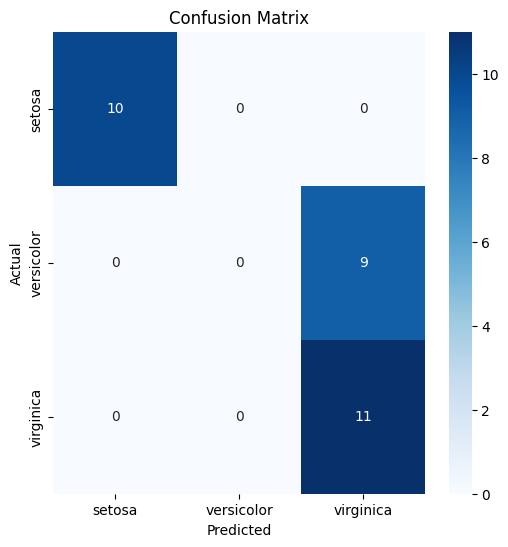

In [ ]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    predictions = torch.argmax(test_outputs, dim=1)
    y_true = torch.argmax(y_test, dim=1)

    accuracy = accuracy_score(y_true, predictions)
    precision = precision_score(y_true, predictions, average='weighted')
    recall = recall_score(y_true, predictions, average='weighted')
    f1 = f1_score(y_true, predictions, average='weighted')
    cm = confusion_matrix(y_true, predictions)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1:.4f}')

    # Plot confusion matrix
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=data.target_names, yticklabels=data.target_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

- **Plot training and validation loss curves over epochs using Matplotlib.**

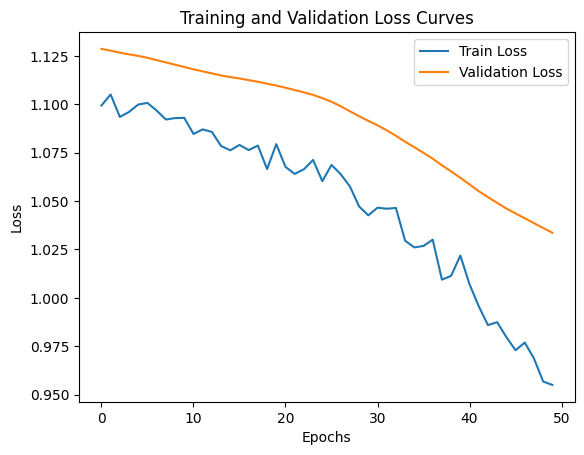

In [ ]:
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Curves')
plt.show()

### 4. Set Up Experiment Tracking with Weights & Biases (W&B) (30 %)
- Log the following details:
  - **Model architecture**: Number of layers, neurons, activation functions.
  - **Hyperparameters**: Learning rate, batch size, number of epochs.
  - **Training and validation loss per epoch.**
  - **Final evaluation metrics.**
  - **Confusion matrix and loss curve visualizations.**

In [ ]:
import wandb

In [ ]:
wandb.init(name=f"Run 10", project="mlp-iris", config={
    "epochs": 50,
    "batch_size": 32,
    "lr": 0.001,
    "hidden_size": 16,
    "architecture": {
        "n_layers": 3,
        "layers": [
            {"name": "input_layer", "neurons": 4},
            {"name": "hidden_layer", "neurons": 16, "activation": "ReLU"},
            {"name": "output_layer", "neurons": 3, "activation": "Softmax"}
        ]
    }
})

#### Writing the whole training loop again, with W&B logging

Epoch [10/50], Loss: 1.1100, Val Loss: 1.0760
Epoch [20/50], Loss: 1.0442, Val Loss: 1.0678
Epoch [30/50], Loss: 1.0500, Val Loss: 1.0565
Epoch [40/50], Loss: 1.0364, Val Loss: 1.0394
Epoch [50/50], Loss: 0.9865, Val Loss: 1.0178


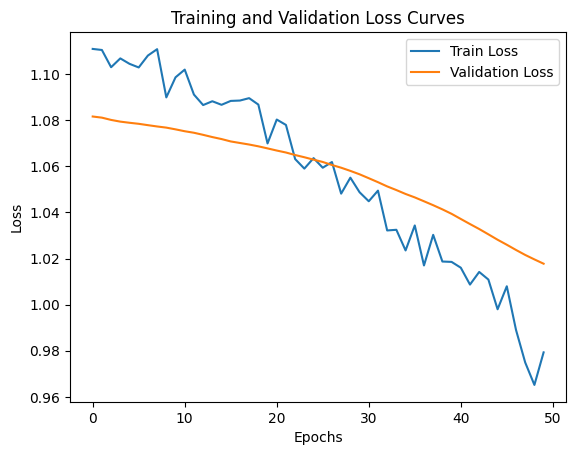

Accuracy: 0.8333
Precision: 0.8481
Recall: 0.8333
F1-score: 0.8316


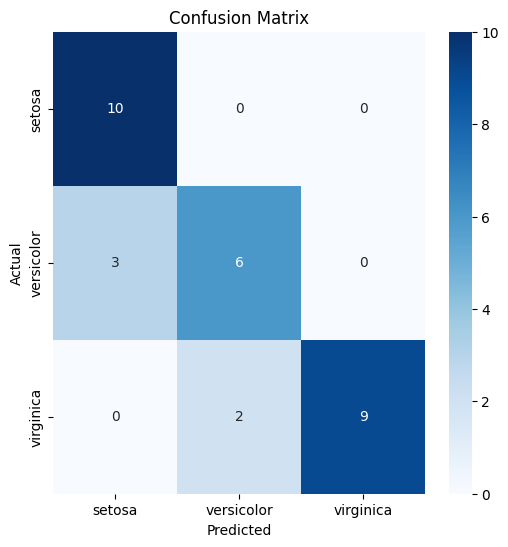

accuracy,▁
f1_score,▁
precision,▁
recall,▁
train_loss,███████▇█▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▃▂▁▁
val_loss,███████▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▅▅▅▅▅▄▄▄▃▃▃▃▂▂▂▁▁
accuracy,0.83333
f1_score,0.83162
precision,0.84808
recall,0.83333
train_loss,0.97929


In [ ]:
model = MLP(input_size, hidden_size, output_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_losses = []
epochs = 50
for epoch in range(epochs):
  train_loss = 0
  model.train()  # set the model to training mode
  for batch_X, batch_y in train_loader:
    outputs = model(batch_X)
    loss = criterion(outputs, torch.argmax(batch_y, dim=1))

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

  train_loss /= len(train_loader)
  train_losses.append(train_loss)


  # Validation
  model.eval() # Set the model to evaluation mode
  with torch.no_grad():
    val_loss = 0
    for batch_X, batch_y in val_loader:
        outputs = model(batch_X)
        val_loss += criterion(outputs, torch.argmax(batch_y, dim=1)).item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

  if((epoch+1) % 10 == 0):
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}') #logging to console
  wandb.log({"train_loss": train_loss, "val_loss": val_loss}) # logging to w&b

plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Curves')
loss_curves = plt.gcf()
wandb.log({"confusion_matrix": wandb.Image(loss_curves)}) # loss curve plot to w&b
plt.show()


# testing
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    predictions = torch.argmax(test_outputs, dim=1)
    y_true = torch.argmax(y_test, dim=1)

    accuracy = accuracy_score(y_true, predictions)
    precision = precision_score(y_true, predictions, average='weighted')
    recall = recall_score(y_true, predictions, average='weighted')
    f1 = f1_score(y_true, predictions, average='weighted')
    cm = confusion_matrix(y_true, predictions)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1:.4f}')

     # final evaluation metrics to w&b
    wandb.log({
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    })

    # Plot confusion matrix
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=data.target_names, yticklabels=data.target_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    cm_fig = plt.gcf()
    wandb.log({"confusion_matrix": wandb.Image(cm_fig)}) # confusion matrix plot to w&b
    plt.show()

wandb.finish() # required in notebooks